# RP-GPFA: Lorenz attractor

Recognition Parametrised GPFA (RP-GPFA) recovers the Lorenz dynamics from Poisson Noise observation
without modeling explicitely its generative process.

The Lorenz attractor obeys

\begin{equation}
\begin{split}
\dot z_1  &= \sigma (z_2 - z_1) \\
\dot z_2  &= z_1 (\rho - z_3) - z_2 \\
\dot z_3  &= z_1 z_2 - \beta z
\end{split}
\end{equation}

From which we decude the rates $\mathsf{r}(t) = \exp( C \mathsf{z}(t) + d)$ and the observations

\begin{equation}
\mathsf{x}(t) \sim \text{Poisson} ( \mathsf{r}(t))
\end{equation}

For $n=1..N$, each observation correspond to a slightly different initialisation of the the attractor,
noise sampled from a Gaussian process, and Poisson sampling.


Imports:

In [1]:
import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt
from recognition_parametrised_gpfa import RPGPFA
from kernels import RBFKernel
import torch.nn.functional as F
from save_load import save_gprpm
from utils_generate_toydatasets import generate_lorenz

from mpl_toolkits import mplot3d

from save_load import  load_gprpm
from utils_process import plot_summary, plot_factors_prior, plot_loss

Problem setting:

In [2]:
# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# GPUs ?
dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dimension of the problem
dim_observations = 200
num_observations = 10
len_observations = 100
num_inducing_points = 50
dim_latent_true = 3

# Generate Lorenz Dynamics
dtt_simulation = 0.001   # a.u
len_simulation = 3e3
num_simulation = num_observations
dim_simulation = 3
init_simulation = np.array([2.3274,  3.8649, 18.2295])
vari_simulation = 0.1

# Normalize Lorenz Dynamics to [-1, 1]
lorenz_raw = torch.tensor(generate_lorenz(num_simulation, int(len_simulation) -1, dtt_simulation, init_simulation, vari_simulation), dtype=dtype)
lorenz_nor = lorenz_raw.reshape(lorenz_raw.shape[0] * lorenz_raw.shape[1], dim_simulation)
lorenz_nor -= lorenz_nor.min(dim=0, keepdim=True)[0]
lorenz_nor /= lorenz_nor.max(dim=0, keepdim=True)[0]
lorenz_nor = 2 * lorenz_nor - 1

# Reshape Dynamics
lorenz_nor = lorenz_nor.reshape(num_simulation, int(len_simulation), dim_simulation)
time_idx = np.linspace(0, len_simulation-1, len_observations).round().astype(int)
lorenz_nor = lorenz_nor[:, time_idx]

# Add Gaussian Noise To each trajectories
noise_kernel = RBFKernel(0.1 * torch.ones(dim_simulation), 0.1 * torch.ones(dim_simulation))
KK = noise_kernel(torch.linspace(0, 1, len_observations).unsqueeze(-1), torch.linspace(0, 1, len_observations).unsqueeze(-1))
LL = torch.linalg.cholesky(KK + 1e-6 * torch.eye(len_observations).unsqueeze(0) )
noise = matmul(LL, torch.randn(dim_simulation, len_observations, num_observations)).permute(2, 1, 0).detach()
lorenz_nor = lorenz_nor + noise + 0 * 2 * torch.rand(lorenz_nor.shape)


# Unfold dynamics for ploting
lorenz_nor = lorenz_nor.reshape(num_simulation * len_observations, dim_simulation)
lorenz_nor = lorenz_nor[..., :dim_latent_true]

# True Latents
latent_true_unfolded = lorenz_nor
latent_true = latent_true_unfolded.reshape(num_observations, len_observations, dim_latent_true)

# Map to observations
C = torch.rand(lorenz_nor.shape[-1], dim_observations)

# Rates
rates_unfoled = matmul(lorenz_nor, C)
rates = rates_unfoled.reshape(num_observations, len_observations, dim_observations)

# Observations
#observations = rates + 0.3 * torch.randn(rates.shape)
observations = torch.poisson(torch.exp((rates - rates.min())))
observations_unfoled = observations.reshape(num_observations * len_observations, dim_observations)

Plot Lorenz dynamics

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones

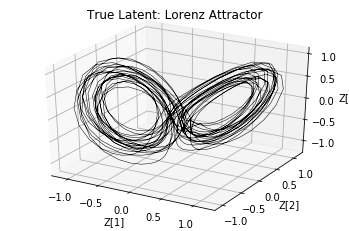

In [3]:
if dim_latent_true == 3:
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(lorenz_nor[:, 0], lorenz_nor[:, 1], lorenz_nor[:, 2], lw=0.5, color='k')
    ax.set_xlabel("Z[1]")
    ax.set_ylabel("Z[2]")
    ax.set_zlabel("Z[3]")
    ax.set_title("True Latent: Lorenz Attractor")
elif dim_latent_true == 2:
    plt.figure()
    plt.plot(lorenz_nor[:, 0], lorenz_nor[:, 1], lw=0.5, color='k')
    plt.xlabel("Z[1]")
    plt.ylabel("Z[2]")
    plt.title("True Latent: Lorenz Attractor")
else:
    plt.figure()
    yy = lorenz_nor.reshape(num_simulation, len_observations, dim_latent_true)
    for nn in range(num_observations):
        plt.plot(yy[nn], color='k')
    plt.title("True Latent: Lorenz Attractor")
    plt.ylabel('Z[1]')
    plt.xlabel('Time [a.u]')



Observation Summary

Text(0.5, 1, 'Latent#2')

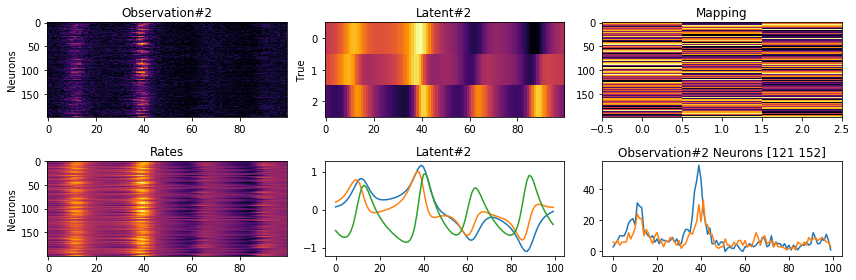

In [4]:
# Plot Observation Summary
plt.figure(figsize=(3*4, 4))
plot_n = 2
plot_num = 2
plot_id = np.random.choice(dim_observations, plot_num)
cmap = 'inferno'

# Plot Observations
plt.subplot(2, 3, 1)
plt.imshow(observations[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.ylabel('Neurons')
plt.title('Observation#' + str(plot_n))

# Plot Rates
plt.subplot(2, 3, 4)
plt.imshow(rates[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.title('Rates')
plt.ylabel('Neurons')

# Plot Observations
plt.subplot(2, 3, 6)
plt.plot(observations[plot_n, :, plot_id])
plt.title('Observation#' + str(plot_n) + ' Neurons ' + str(plot_id))

# Plot Mapping
plt.subplot(2, 3, 3)
plt.imshow(C.transpose(-1, -2), aspect='auto', cmap='inferno')
plt.title('Mapping')

# Plot True Latent
plt.subplot(2, 3, 2)
plt.imshow(latent_true[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.ylabel('True')
plt.title('Latent#' + str(plot_n))

# Plot True Latents
plt.subplot(2, 3, 5)
plt.plot(latent_true[plot_n])
plt.tight_layout()
plt.title('Latent#' + str(plot_n))


Set up and launch fit

In [5]:
# Normalise observations.
observations = observations.reshape(num_observations * len_observations, dim_observations)
o_mean, o_std = torch.mean(observations, dim=0, keepdim=True), torch.std(observations, dim=0, keepdim=True)
observations = (observations - o_mean) / o_std
observations = observations.reshape(num_observations, len_observations, dim_observations)

# Move to GPU if necessary
observations = torch.tensor(observations, dtype=dtype, device=device)
observation_locations = torch.linspace(0, 1, len_observations, dtype=dtype, device=device).unsqueeze(-1)
inducing_locations = torch.linspace(0, 1, num_inducing_points, dtype=dtype, device=device).unsqueeze(-1)

# Break Into Multiple Factors
num_factors = 1
num_full = (np.floor(dim_observations / num_factors)).astype(int)
obs = tuple([observations[..., num_full*i:num_full*(i+1)] for i in range(num_factors)])

# Linear / Non Linear Network
linear_networks = False
dim_hidden0 = [] if linear_networks else [10, 10]
non_lineraity0 = torch.nn.Identity() if linear_networks else F.relu

# Copy for each factors
dim_hidden = tuple([dim_hidden0 for _ in range(num_factors)])
neural_net = tuple(['perceptron' for _ in range(num_factors)])
nonlinearity = tuple([non_lineraity0 for _ in range(num_factors)])

fit_params = {'dim_latent': dim_latent_true,
               'inference_mode': 'VariationalBound',
               'constraint_factors': 'fixed_diag',
               'num_epoch': 100000,
               'optimizer_prior': {'name': 'Adam', 'param': {'lr': 1e-3}},
               'optimizer_factors': {'name': 'Adam', 'param': {'lr': 1e-5}},
               'optimizer_inducing_points': {'name': 'Adam', 'param': {'lr': 1e-3}},
               'gp_kernel': 'RBF',
               'dim_hidden': dim_hidden, # was all 20
               'nn_type': neural_net,
               'nonlinearity': nonlinearity,
               'minibatch_size': len_observations,
               'pct':0.1
                }

model = RPGPFA(obs, observation_locations, inducing_locations=inducing_locations, fit_params=fit_params)

loss_tot = model.fit(obs)


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RP-GPFA on GPU
Epoch 10000/100000 Loss: 2.040204e+00
Epoch 20000/100000 Loss: 1.744861e+00
Epoch 30000/100000 Loss: 1.509106e+00
Epoch 40000/100000 Loss: 1.360192e+00
Epoch 50000/100000 Loss: 1.252337e+00
Epoch 60000/100000 Loss: 1.179017e+00
Epoch 70000/100000 Loss: 1.131105e+00
Epoch 80000/100000 Loss: 1.097455e+00
Epoch 90000/100000 Loss: 1.073360e+00
Epoch 100000/100000 Loss: 1.052312e+00


Save model

In [6]:
fname = './../RPGPFA_demo_results/lorenz.pkl'
save_gprpm(fname, model, observations=obs, true_latent=latent_true)

Load and plot Model

RP-GPFA on GPU


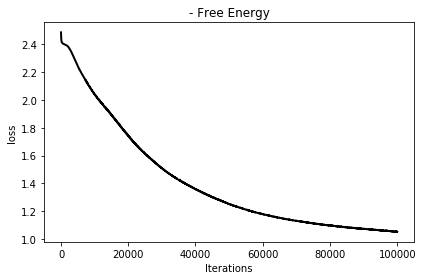

In [8]:
model, obs, latent_true = load_gprpm(fname)
plot_loss(model)

Regress True to discovered latents 

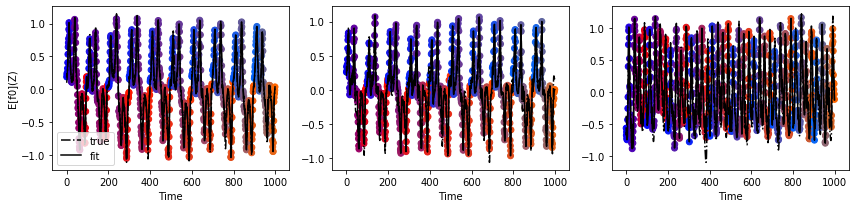

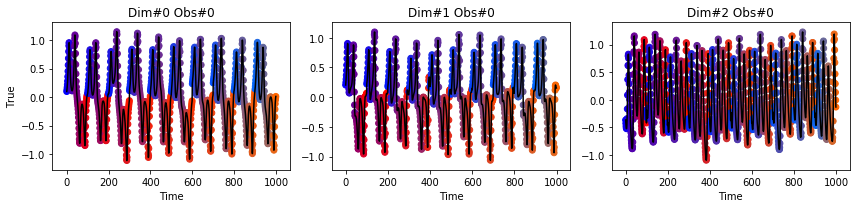

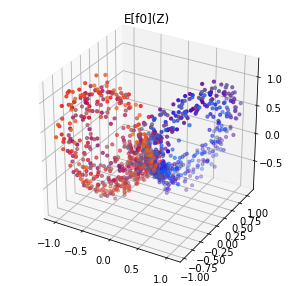

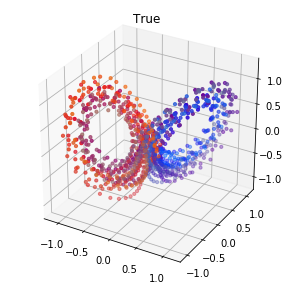

In [20]:
regress_param = {
    'train_pct': 0.8,
    'kernel_param': {'type': 'RBF', 'param': {'scale': torch.ones(1), 'lengthscale': 1e1 * torch.ones(1)}}
}

plot_summary(model, latent_true=latent_true, plot_observation='all', plot_factors_id=[0],
             plot_regressed='krr', plot_true=True, regress_param=regress_param)

Check that the factors mixture approximate the prior:

\begin{equation}
F_{\theta j} (\mathsf{z}_t) \approx p_\theta ^z (\mathsf{z}_t)
\end{equation}

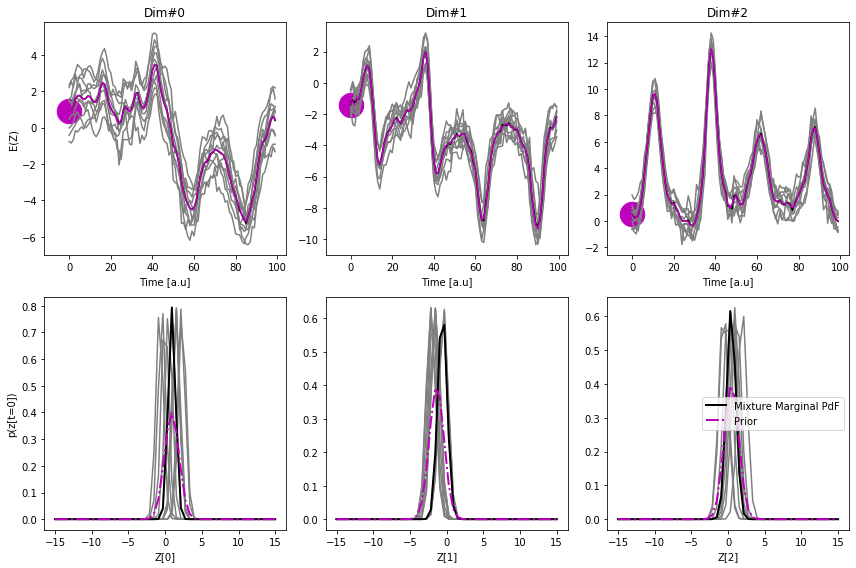

In [10]:
plot_factors_prior(model)